In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'src/')
import acs5
import nyserda_acs
import prices
import project_sunroof
import nyserda
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

%matplotlib inline

## Getting the data

In [2]:
raw_data = nyserda_acs.merging_data()
raw_data=raw_data[raw_data['households']>0]

## Generating sample weights

In [3]:
#Duplicate positive rows
duplic = raw_data.loc[raw_data['Project_yes']==1,:]
duplic.loc[:,'Project_yes'] =0
duplic.loc[:,'Duplicate'] = 'Yes'
duplic.loc[:,'weight'] = (duplic.loc[:,'households']-duplic.loc[:,'Project_Number'])
duplic=duplic[duplic['weight']>0]
#Creating weights in old data
raw_data.loc[raw_data['Project_yes'] == 1, 'weight'] = raw_data['Project_Number']
raw_data.loc[raw_data['Project_yes'] == 0, 'weight'] = raw_data['households']
raw_data['Duplicate']='No'
#Merging data 
#Concatenating
all_data = raw_data.append(duplic, ignore_index=True)

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [4]:
# Imputing missing values
all_data.loc[all_data['yearly_sunlight_kwh_total'].isnull(), 'yearly_sunlight_kwh_total'] = 0
all_data.loc[all_data['percent_qualified'].isnull(), 'percent_qualified'] = 200
all_data.loc[all_data['Avg_hh_size'].isnull(), 'Avg_hh_size']=np.mean(all_data.Avg_hh_size)
all_data.loc[all_data['median_rooms'].isnull(), 'median_rooms']=5.320409

In [5]:
list(all_data.columns)

['100k_150k',
 '10_19_units',
 '10k_15k',
 '12th_no_dip',
 '150k_200k',
 '15k_25k',
 '1_room',
 '1_unit_attached',
 '1_unit_detached',
 '20+_units',
 '200k_more',
 '25k_35k',
 '2_rooms',
 '2_units',
 '35k_50k',
 '3_4_units',
 '3_rooms',
 '4_rooms',
 '50k_75k',
 '5_9_units',
 '5_rooms',
 '6_rooms',
 '75k_100k',
 '7_rooms',
 '8_rooms',
 '9_more_rooms',
 'Affordable_Solar',
 'Associate',
 'Avg_hh_size',
 'Bachelors',
 'Community_Distributed_Generation',
 'Duplicate',
 'Expected_KWh_Annual_Production',
 'GEOID10',
 'Graduate',
 'Heating_coal_coke',
 'Heating_electricity',
 'Heating_fuelkero',
 'Heating_gas',
 'Heating_gas_tank',
 'Heating_no',
 'Heating_other',
 'Heating_solar',
 'Heating_wood',
 'Hh_w_children',
 'HighSchool',
 'Housing_Units',
 'Less_10k',
 'Less_9th',
 'Mean_income',
 'Mean_price',
 'Median_age',
 'Median_income',
 'Median_unit_values',
 'NAME',
 'Occupied_units',
 'Occupied_units_heating',
 'Percent_10+_units',
 'Percent_100k_150k',
 'Percent_10_19_units',
 'Percent_10

## Creating AUC Score

In [6]:
# define scoring function 
def custom_auc(ground_truth, predictions):
    # I need only one column of predictions["0" and "1"]. You can get an error here
    # while trying to return both columns at once
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
    return auc(fpr, tpr)

# to be standart sklearn's scorer        
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

## Large model matrix

In [7]:
all_columns = list(all_data.columns)
acs= acs5.Get_census_data()
acs_data = acs.get_acs_all()
variables_large = acs.education_percent + acs.other_households + acs.units_percent + acs.heating_percent + acs.rooms_percent

In [8]:
variables_large.append('Project_yes')
#variables_large.append('Mean_price')
#variables_large.append('Var_price')
variables_large.append('percent_qualified')
variables_large.append('yearly_sunlight_kwh_total')
variables_large.append('weight')
variables_large.append('Duplicate')
variables_large.append('GEOID10')
variables_large.append('county_name')
variables_large.append('households')
df_large=all_data[variables_large]

In [9]:
df_large =df_large.dropna()
y_large=df_large['Project_yes']
weights_large=df_large['weight']
X_large=df_large.drop(['Project_yes', 'weight','Duplicate', 'GEOID10','county_name', 'households', 'Percent_1_unit'], axis=1)

In [10]:
X_large.shape

(6015, 40)

## Models using large matrix

In [11]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_large, y_large, weights_large, test_size=0.3, random_state=42)

 Gradient Boosting Classifier w/sample weights

In [12]:
gbc = GradientBoostingClassifier()
gbc_search = GridSearchCV(gbc, param_grid = {'n_estimators' : [1000, 10000], 'subsample' :[0.8],
                                           'max_depth': [2,3], 'learning_rate' : [0.01, 0.001]}, 
                     scoring=my_auc, fit_params={'sample_weight': weights_train}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [13]:
gbc_fitted = gbc_search.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.631125, total=   6.0s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.656102, total=   6.0s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s


[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.604230, total=   6.3s
[CV] n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.3s remaining:    0.0s


[CV]  n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.609004, total=  56.8s
[CV] n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.625771, total=  56.4s
[CV] n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2 
[CV]  n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=2, score=0.588664, total=  56.6s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.619718, total=   8.5s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.634754, total=   8.5s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.586622, total=   8.4s
[CV] n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=10000, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.589818, total= 1.4min
[CV] n_estimators

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 15.8min finished


In [14]:
gbc_fitted.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

In [54]:
gbc_best = GradientBoostingClassifier(n_estimators=1220,max_depth=2, learning_rate=0.001, subsample=0.8)
gbc_best_fitted = gbc_best.fit(X_large, y_large, sample_weight=weights_large)

In [55]:
importance_values = gbc_best_fitted.feature_importances_

In [56]:
feature_importances = 100*gbc_best_fitted.feature_importances_ / np.sum(gbc_best_fitted.feature_importances_)

In [57]:
feature_importances

array([  2.03428173e+00,   4.08316990e-01,   3.89401700e-01,
         1.02686585e-01,   1.43042846e+00,   7.32331384e-02,
         1.35314306e-01,   4.35563195e-01,   1.69815157e+00,
         5.48247553e-02,   1.09042848e-01,   1.76134886e+01,
         4.43687045e+00,   1.97296453e+00,   1.50911232e+00,
         0.00000000e+00,   2.87250882e-01,   4.03767079e-01,
         4.66660596e-01,   9.00228574e-01,   8.70361680e-02,
         6.36636873e-02,   1.43343595e+01,   6.25536933e-02,
         1.30739342e-01,   1.37989281e-03,   5.53168370e-03,
         4.57455773e-02,   1.81023560e+00,   6.30176578e-02,
         8.32886253e-01,   5.12678993e+00,   1.05723839e-01,
         1.17435622e+00,   1.18058342e+01,   5.53188023e+00,
         2.10111093e+01,   2.40706765e+00,   2.72797774e-02,
         9.11221452e-01])

In [58]:
columns = np.array(X_large.columns)

In [59]:
feat = pd.DataFrame()
feat['relative_feature_importances']=feature_importances
feat['feature_names']=columns
feat['feature_importance']=importance_values

In [60]:
feat.to_csv('feature_imporance.csv')

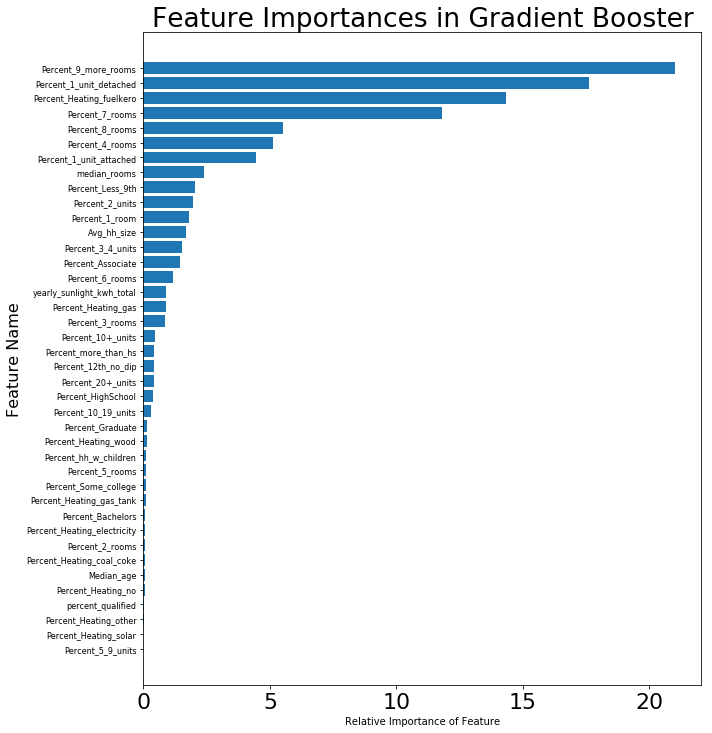

In [61]:
gbc_best_fitted.feature_importances_
feature_importances = 100*gbc_best_fitted.feature_importances_ / np.sum(gbc_best_fitted.feature_importances_)
feature_importances, feature_names, feature_idxs = zip(*sorted(zip(feature_importances, list(X_large.columns), range(len(X_large.columns)))))

width = 0.8

idx = np.arange(len(X_large.columns))

fig, ax = plt.subplots(figsize=(10,12))
ax.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names, fontsize=8)

ax.set_title("Feature Importances in Gradient Booster")
ax.set_xlabel('Relative Importance of Feature', fontsize=10)
ax.set_ylabel('Feature Name', fontsize=16)
fig.savefig('feat_imp_sep8.png')

In [62]:
# Adding results to orginal Data Frames
df_large['result']=gbc_best_fitted.predict_proba(X_large)[:,1]

In [63]:
df_to_tableau= df_large[df_large['Project_yes']==0]

In [64]:
df_to_tableau.to_csv('output_sept19.csv')

In [65]:
df_large.describe()

,Percent_Less_9th,Percent_12th_no_dip,Percent_HighSchool,Percent_Some_college,Percent_Associate,Percent_Bachelors,Percent_Graduate,Percent_more_than_hs,Avg_hh_size,Median_age,...,Percent_8_rooms,Percent_9_more_rooms,median_rooms,Project_yes,percent_qualified,yearly_sunlight_kwh_total,weight,GEOID10,households,result
count,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,...,6015.000000,6015.000000,6015.000000,6015.000000,6015.000000,6.015000e+03,6015.000000,6.015000e+03,6015.000000,6015.000000
mean,0.062039,0.078039,0.280322,0.166529,0.088960,0.183708,0.140403,0.579601,2.692034,39.544472,...,0.082252,0.101888,5.320745,0.198504,109.311963,7.147635e+06,1207.368745,3.606246e+10,1538.773400,0.011931
std,0.063335,0.054188,0.100124,0.050862,0.040072,0.091024,0.105248,0.160102,0.531530,7.017340,...,0.068406,0.091098,1.205510,0.398907,57.705506,1.138075e+07,908.119485,3.224257e+07,797.344834,0.011668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.030000,11.300000,...,0.000000,0.000000,1.300000,0.000000,21.212121,0.000000e+00,1.000000,3.600100e+10,2.000000,0.005269
25%,0.019440,0.037396,0.219068,0.133333,0.058932,0.114544,0.064054,0.462948,2.350000,34.700000,...,0.023482,0.033709,4.300000,0.000000,70.098957,0.000000e+00,577.000000,3.604701e+10,1014.000000,0.005642
50%,0.038308,0.067114,0.286698,0.167415,0.086894,0.169708,0.111167,0.572153,2.610000,40.300000,...,0.072031,0.085898,5.500000,0.000000,81.764706,3.381567e+06,1178.000000,3.606101e+10,1445.000000,0.011733
75%,0.083015,0.106013,0.350957,0.198669,0.116232,0.238077,0.187382,0.687781,2.980000,44.400000,...,0.123052,0.144573,6.200000,0.000000,200.000000,9.007294e+06,1718.500000,3.608305e+10,1913.000000,0.014971
max,0.445956,0.400000,0.793103,0.448276,0.318182,0.764706,0.695565,1.000000,6.270000,82.000000,...,0.809524,1.000000,8.500000,1.000000,200.000000,1.720241e+08,12305.000000,3.612315e+10,12316.000000,0.658374


Logistic Regression w/ sample weights

In [66]:
log = LogisticRegression()
log_fitted = log.fit(X_train,y_train,sample_weight=weights_train)

In [67]:
log_best = LogisticRegression()
log_best_fitted = log_best.fit(X_large,y_large,sample_weight=weights_large)

Random Forest w/sample weights

In [68]:
rf=RandomForestClassifier()

rf_search = GridSearchCV(rf, param_grid ={'n_estimators':[10, 20, 100], 'max_features':['sqrt', 'log2'], 'max_depth': [2,3,4,5]}, scoring=my_auc, fit_params={'sample_weight': np.array(weights_train)}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [30]:
rf_fitted = rf_search.fit(X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.659176, total=   0.1s
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.685440, total=   0.1s
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.596786, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.681563, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.662249, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.598926, total=   0.1s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.678901, total=   0.7s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.669563, total=   0.7s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.605845, total=   0.7s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=0.689889, total=   0.1s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=

[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.641611, total=   0.2s
[CV] max_features=sqrt, n_estimators=20, max_depth=5 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.629015, total=   0.2s
[CV] max_features=sqrt, n_estimators=20, max_depth=5 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.565214, total=   0.2s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.584293, total=   1.0s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.587992, total=   1.0s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.530716, total=   1.0s
[CV] max_features=log2, n_estimators=10, max_depth=5 .................
[CV]  max_features=log2, n_estimators=10, max_depth=5, score=

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   28.6s finished


In [31]:
rf_fitted.best_params_

{'max_depth': 2, 'max_features': 'log2', 'n_estimators': 20}

In [69]:
rf_best=RandomForestClassifier(max_depth=2, max_features= 'log2', n_estimators=20)
rf_best_fitted = rf_best.fit(X_large, y_large, sample_weight=np.array(weights_large))

## ROC Curves

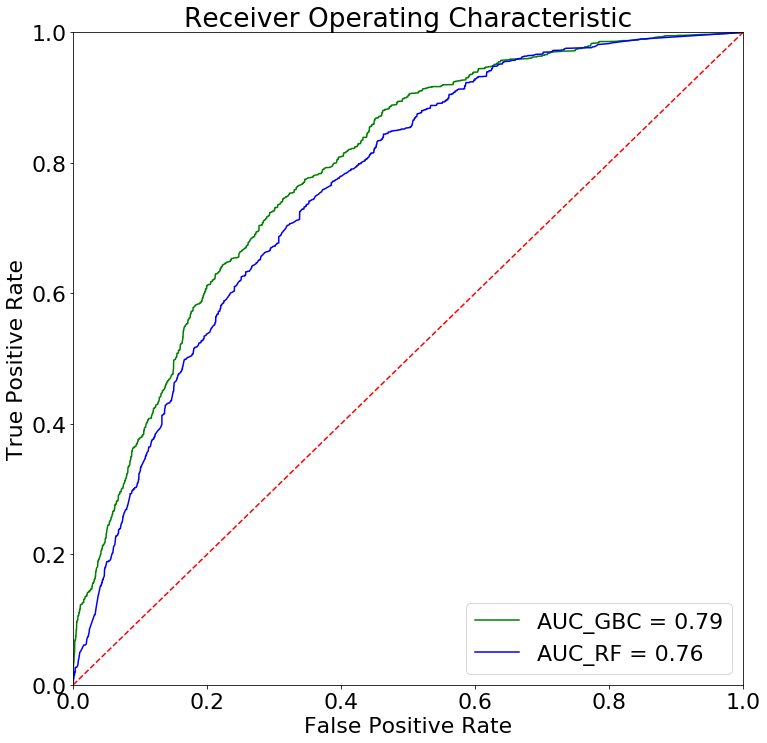

In [70]:
from sklearn import metrics
import matplotlib 

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


# calculate the fpr and tpr for all thresholds of the classification
#Gradient Boosting
gbc_probs = gbc_best_fitted.predict_proba(X_large)[:,1]
gbc_fpr, gbc_tpr, gbc_threshold = metrics.roc_curve(y_large, gbc_probs, sample_weight=weights_large)
gbc_roc_auc = metrics.auc(gbc_fpr, gbc_tpr)

#Logistic Regression
#log_probs = log_best_fitted.predict_proba(X_large)[:,1]
#log_fpr, log_tpr, log_threshold = metrics.roc_curve(y_large, log_probs,sample_weight=weights_large)
#log_roc_auc = metrics.auc(log_fpr, log_tpr)

#Random Forest
rf_probs = rf_best_fitted.predict_proba(X_large)[:,1]
rf_fpr, rf_tpr, rf_threshold = metrics.roc_curve(y_large, rf_probs,sample_weight=weights_large)
rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)

# method I: plt
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Receiver Operating Characteristic')
ax.plot(gbc_fpr, gbc_tpr, 'b', label = 'AUC_GBC = %0.2f' % gbc_roc_auc, color='green')
#ax.plot(log_fpr, log_tpr, 'b', label = 'AUC_LOG = %0.2f' % log_roc_auc, color='red')
ax.plot(rf_fpr, rf_tpr, 'b', label = 'AUC_RF = %0.2f' % rf_roc_auc , color='blue')
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
fig.savefig('roc_sep8.png')
plt.show()

## Selecting the number of estimators

In [34]:
gbc_fitted.best_params_

{'learning_rate': 0.001,
 'max_depth': 2,
 'n_estimators': 1000,
 'subsample': 0.8}

In [35]:
N_ESTIMATORS=4000

In [36]:
model = GradientBoostingClassifier(n_estimators=N_ESTIMATORS,max_depth=2, learning_rate=0.001, subsample=0.8)
model.fit(X_train, y_train, sample_weight=weights_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=4000, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

In [37]:
def log_loss(y, y_hat, weights):
    return (1.0 / y.shape[0]) * np.sum(weights*(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)))

In [38]:
train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict_proba(X_train)):
    train_score[i] = -log_loss(y_train, y_pred[:, 1], weights_train)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict_proba(X_test)):
    test_score[i] = -log_loss(y_test, y_pred[:, 1], weights_test)

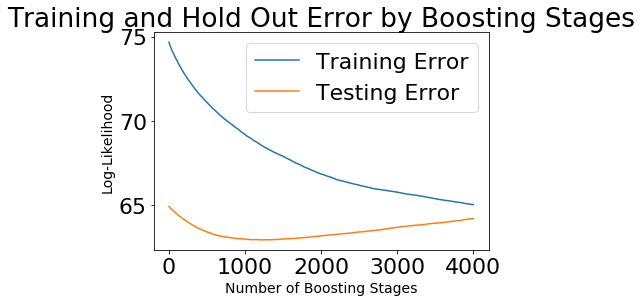

In [39]:
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Log-Likelihood', fontsize=14)
plt.legend(loc="upper right")


plt.savefig('training-and-testing-error.png', bbox_inches='tight')

In [40]:
np.argmin(test_score)

1220

## Simple model matrix

In [41]:
variables_simple = ['Percent_Less_9th','Percent_more_than_hs', 'Percent_1_unit','Avg_hh_size',
                'Percent_hh_w_children', 'Percent_10+_units', 'Percent_Heating_electricity',
                'yearly_sunlight_kwh_total'  , 'Percent_9_more_rooms', 'percent_qualified',
                'Project_yes','weight','Duplicate']

In [42]:
df_simple= all_data[variables_simple]

In [43]:
y_simple=df_simple['Project_yes']
weights_simple=df_simple['weight']
X_simple=df_simple.drop(['Project_yes', 'weight','Duplicate'], axis=1)

## Model using small matrix

In [44]:
X_train_simple, X_test_simple, y_train_simple, y_test_simple, weights_train_simple, weights_test_simple = train_test_split(X_simple, y_simple, weights_simple, test_size=0.3, random_state=42)

In [45]:
gbc_simple = GradientBoostingClassifier()
gbc_search_simple = GridSearchCV(gbc_simple, param_grid = {'n_estimators' : [500, 1000, 2000], 'subsample' :[0.5,0.8],
                                           'max_depth': [2,3,4,5], 'learning_rate' : [0.1, 0.01, 0.001]}, 
                      scoring=my_auc, fit_params={'sample_weight': weights_train_simple}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [46]:
gbc_fitted_simple = gbc_search_simple.fit(X_train_simple,y_train_simple)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.563104, total=   1.1s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.587404, total=   1.1s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.518299, total=   1.1s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.539944, total=   1.2s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s


[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.581900, total=   1.2s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2 .
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.609385, total=   1.2s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.609464, total=   2.2s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.634180, total=   2.2s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.1, max_depth=2, score=0.539220, total=   2.3s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=2 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=2, score=0.592513, total=   2.7s
[CV] n_estimators=1000, subsample=0

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.py:490: RuntimeWarning: overflow encountered in multiply
  np.sum(sample_weight * ((y * pred) - np.logaddexp(0.0, pred))))
/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.py:1093: RuntimeWarning: invalid value encountered in double_scalars
  sample_weight[~sample_mask]))


[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=4, score=0.528917, total=   4.0s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=4 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=4, score=0.490841, total=   4.2s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=4 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.1, max_depth=4, score=0.534208, total=   4.3s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.1, max_depth=4 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.1, max_depth=4, score=0.573963, total=   7.8s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.1, max_depth=4 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.1, max_depth=4, score=0.521930, total=   7.0s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.1, max_depth=4 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.1, max_depth=4, score=0.505556, total=   7.1s
[CV] n_estimators=2000, subsample

[CV]  n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.606701, total=   1.7s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.599284, total=   1.7s
[CV] n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=500, subsample=0.8, learning_rate=0.01, max_depth=3, score=0.608994, total=   1.8s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.587656, total=   2.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.592184, total=   2.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.01, max_depth=3, score=0.588488, total=   2.8s
[CV] n_estimators=1000, sub

[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.01, max_depth=5, score=0.514703, total=   9.3s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=5 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=5, score=0.533910, total=  10.4s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=5 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=5, score=0.515462, total=  10.1s
[CV] n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=5 
[CV]  n_estimators=2000, subsample=0.8, learning_rate=0.01, max_depth=5, score=0.543621, total=  10.8s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.626390, total=   1.2s
[CV] n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=500, subsample=0.5, learning_rate=0.001, max_depth=2, score=0.624851, total=   1.2s
[CV] n_estimators=500,

[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=4, score=0.589753, total=   3.9s
[CV] n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=1000, subsample=0.5, learning_rate=0.001, max_depth=4, score=0.590640, total=   3.9s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.599140, total=   4.7s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.591382, total=   4.7s
[CV] n_estimators=1000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=1000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.595332, total=   4.7s
[CV] n_estimators=2000, subsample=0.5, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=2000, subsample=0.5, learning_rate=0.001, max_depth=4, score=0.594179, total=   7.5s
[CV] n_esti

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 15.5min finished


In [48]:
gbc_fitted_simple.best_params_

{'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}

In [49]:
log_simple = LogisticRegression()
log_fitted_simple = log_simple.fit(X_train_simple,y_train_simple,sample_weight=weights_train_simple)

In [50]:
rf_simple=RandomForestClassifier()

rf_search_simple = GridSearchCV(rf, param_grid ={'n_estimators':[10, 20, 100], 'max_features':['sqrt', 'log2'], 'max_depth': [2,3,4,5]}, scoring=my_auc, fit_params={'sample_weight': np.array(weights_train_simple)}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [51]:
rf_fitted_simple = rf_search_simple.fit(X_train_simple,y_train_simple)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.634203, total=   0.1s
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.648996, total=   0.1s
[CV] max_features=sqrt, n_estimators=10, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=sqrt, n_estimators=10, max_depth=2, score=0.649045, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.631524, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.634022, total=   0.1s
[CV] max_features=sqrt, n_estimators=20, max_depth=2 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=2, score=0.645924, total=   0.1s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.632403, total=   0.6s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.631122, total=   0.6s
[CV] max_features=sqrt, n_estimators=100, max_depth=2 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=2, score=0.647411, total=   0.6s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=0.635139, total=   0.1s
[CV] max_features=log2, n_estimators=10, max_depth=2 .................
[CV]  max_features=log2, n_estimators=10, max_depth=2, score=

[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.583502, total=   0.2s
[CV] max_features=sqrt, n_estimators=20, max_depth=5 .................
[CV]  max_features=sqrt, n_estimators=20, max_depth=5, score=0.564394, total=   0.1s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.546207, total=   0.8s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.529956, total=   0.9s
[CV] max_features=sqrt, n_estimators=100, max_depth=5 ................
[CV]  max_features=sqrt, n_estimators=100, max_depth=5, score=0.543337, total=   0.8s
[CV] max_features=log2, n_estimators=10, max_depth=5 .................
[CV]  max_features=log2, n_estimators=10, max_depth=5, score=0.608367, total=   0.1s
[CV] max_features=log2, n_estimators=10, max_depth=5 .................
[CV]  max_features=log2, n_estimators=10, max_depth=5, score=

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   24.9s finished


In [ ]:
weights_train_simple.shape

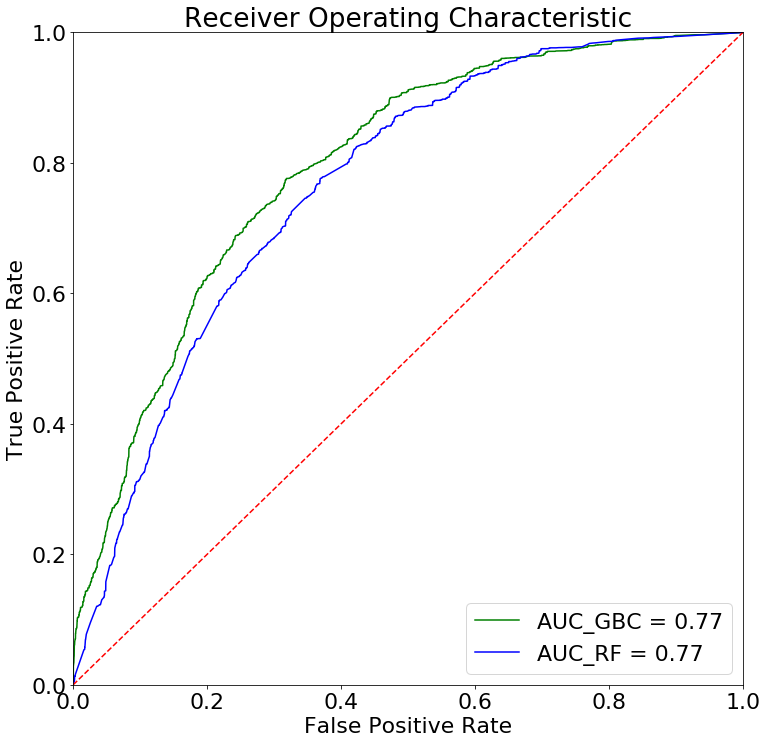

In [52]:
from sklearn import metrics

# calculate the fpr and tpr for all thresholds of the classification
#Gradient Boosting
gbc_probs_simple = gbc_fitted_simple.predict_proba(X_simple)[:,1]
gbc_fpr_simple, gbc_tpr_simple, gbc_threshold_simple = metrics.roc_curve(y_simple, gbc_probs_simple, sample_weight=weights_simple)
gbc_roc_auc_simple = metrics.auc(gbc_fpr_simple, gbc_tpr_simple)

#Logistic Regression
log_probs_simple = log_fitted_simple.predict_proba(X_test_simple)[:,1]
log_fpr_simple, log_tpr_simple, log_threshold_simple = metrics.roc_curve(y_test_simple, log_probs_simple, sample_weight=weights_test_simple)
log_roc_auc_simple = metrics.auc(log_fpr_simple, log_tpr_simple)

#Random Forest
rf_probs_simple = rf_fitted_simple.predict_proba(X_simple)[:,1]
rf_fpr_simple, rf_tpr_simple, rf_threshold_simple = metrics.roc_curve(y_simple, gbc_probs_simple, sample_weight=weights_simple)
rf_roc_auc_simple = metrics.auc(rf_fpr_simple, rf_tpr_simple)

# method I: plt
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Receiver Operating Characteristic')
ax.plot(gbc_fpr, gbc_tpr, 'b', label = 'AUC_GBC = %0.2f' % gbc_roc_auc_simple, color='green')
#ax.plot(log_fpr, log_tpr, 'b', label = 'AUC_LOG = %0.2f' % log_roc_auc_simple, color='red')
ax.plot(rf_fpr, rf_tpr, 'b', label = 'AUC_RF = %0.2f' % rf_roc_auc_simple , color='blue')
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
#fig.savefig('roc_sep8.png')
plt.show()

In [74]:
best_gbc_small = GradientBoostingClassifier(learning_rate= 0.001, max_depth= 2, n_estimators=500, subsample=0.8)
gbc_best_fitted_small = best_gbc_small.fit(X_train_simple, y_train_simple, sample_weight=weights_train_simple)

In [78]:
N_estimators= 1500
train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(best_gbc_small.staged_predict_proba(X_train_simple)):
    train_score[i] = -log_loss(y_train_simple, y_pred[:, 1], weights_train_simple)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(best_gbc_small.staged_predict_proba(X_test_simple)):
    test_score[i] = -log_loss(y_test_simple, y_pred[:, 1], weights_test_simple)

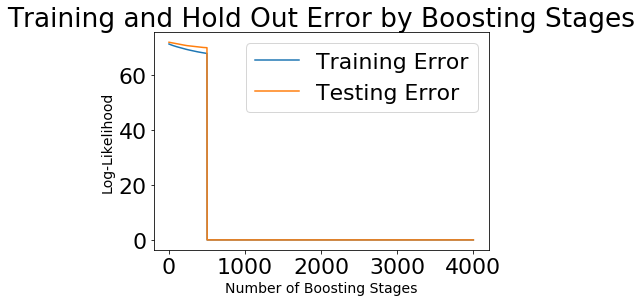

In [79]:
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Log-Likelihood', fontsize=14)
plt.legend(loc="upper right")


plt.savefig('training-and-testing-error.png', bbox_inches='tight')

In [ ]:
gbc_best_fitted.feature_importances_
feature_importances = 100*gbc_best_fitted.feature_importances_ / np.sum(gbc_best_fitted.feature_importances_)
feature_importances, feature_names, feature_idxs = zip(*sorted(zip(feature_importances, list(X_large.columns), range(len(X_large.columns)))))

width = 0.8

idx = np.arange(len(X_large.columns))

fig, ax = plt.subplots(figsize=(10,12))
ax.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names, fontsize=8)

ax.set_title("Feature Importances in Gradient Booster")
ax.set_xlabel('Relative Importance of Feature', fontsize=10)
ax.set_ylabel('Feature Name', fontsize=16)
fig.savefig('feat_imp_sep8.png')